# Modeling

In [1]:
import sys
import numpy as np
import pandas as pd
 
import matplotlib.pyplot as plt 
from skimage import io, util, color, transform
from sklearn import metrics

from statistics import mode
import random
from sklearn.utils import shuffle

from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Flatten, Dense, Dropout, Conv2D, MaxPooling2D

sys.path.append('./src/')
import data_utils
import img_plot

%load_ext autoreload
%autoreload 2

Using TensorFlow backend.


## Load training data

In [2]:
data_train_pos = np.load('./data/output/data_set/data_train_pos.npy')
data_train_pos.shape

(771, 120, 80)

In [3]:
data_train_neg = np.load('./data/output/data_set/data_train_neg.npy')
data_train_neg.shape

(3000, 120, 80)

In [4]:
data_train = np.concatenate((data_train_pos, data_train_neg), axis=0)
data_train.shape

(3771, 120, 80)

In [5]:
# create labels
y_pos = np.ones((data_train_pos.shape[0],), dtype=int)
y_neg = np.zeros((data_train_neg.shape[0],), dtype=int)
y = np.concatenate((y_pos, y_neg), axis=0)
y.shape

(3771,)

In [6]:
# shuffle data
train_set, target = shuffle(data_train, y)

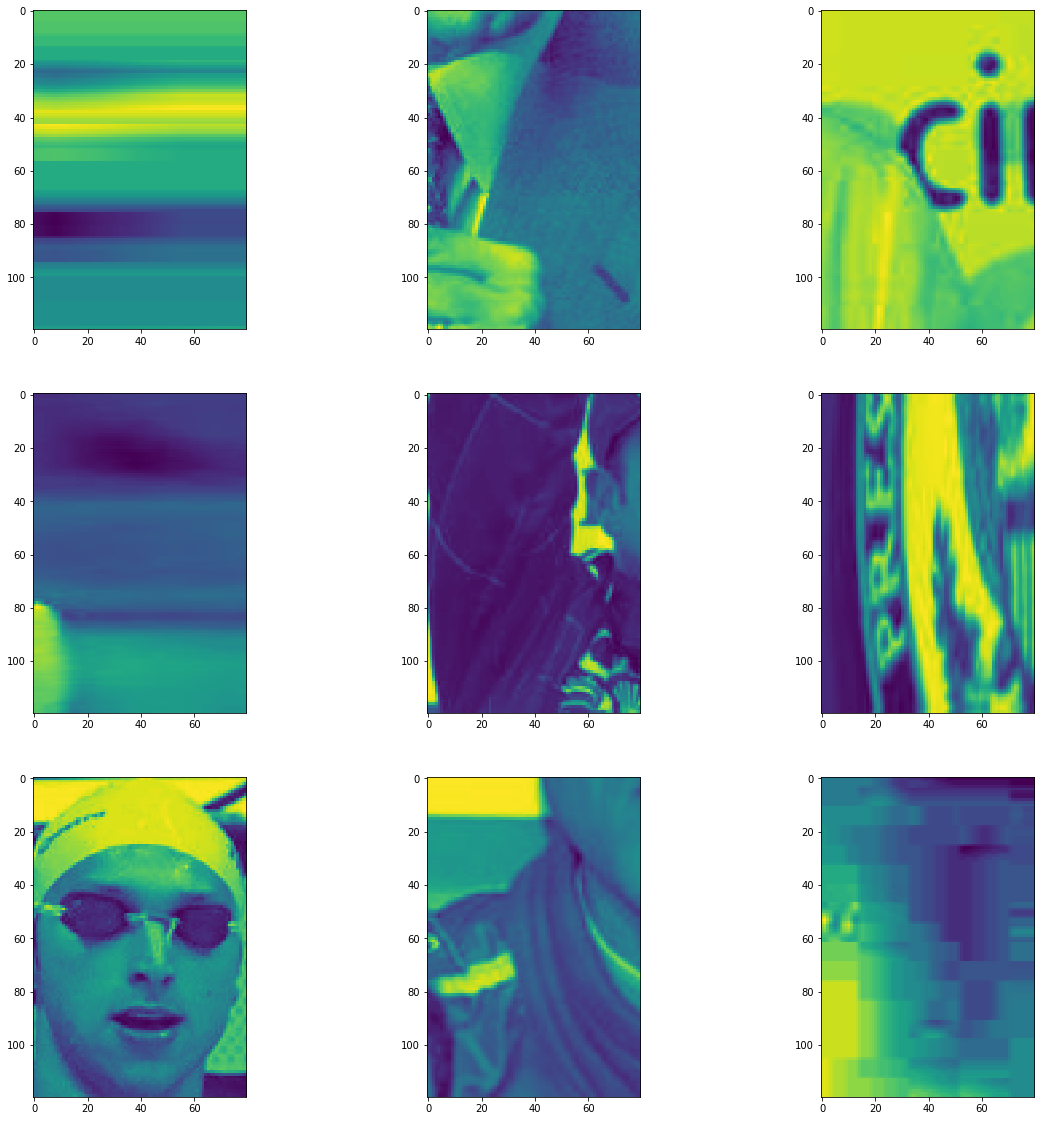

In [7]:
fig, ax = plt.subplots(3, 3, figsize=(20, 20))
idx = 0
nb_sample = train_set.shape[0]
img_idx = random.sample(range(nb_sample), 9)
for i in range(3):
    for j in range(3):
        ax[i,j].imshow(train_set[img_idx[idx],:,:])
        idx += 1
plt.show()

In [8]:
target[img_idx]

array([0, 0, 0, 0, 0, 0, 1, 0, 0])

## Load validation data

In [9]:
data_validation_pos = np.load('./data/output/data_set/data_validation_pos.npy')
data_validation_pos.shape

(513, 120, 80)

In [10]:
data_validation_neg = np.load('./data/output/data_set/data_validation_neg.npy')
data_validation_neg.shape

(2000, 120, 80)

In [11]:
data_validation = np.concatenate((data_validation_pos, data_validation_neg), axis=0)
data_validation.shape

(2513, 120, 80)

In [12]:
y_validation_pos = np.ones((data_validation_pos.shape[0],), dtype=int)
y_validation_neg = np.zeros((data_validation_neg.shape[0],), dtype=int)
label_validation = np.concatenate((y_validation_pos, y_validation_neg), axis=0)
label_validation.shape

(2513,)

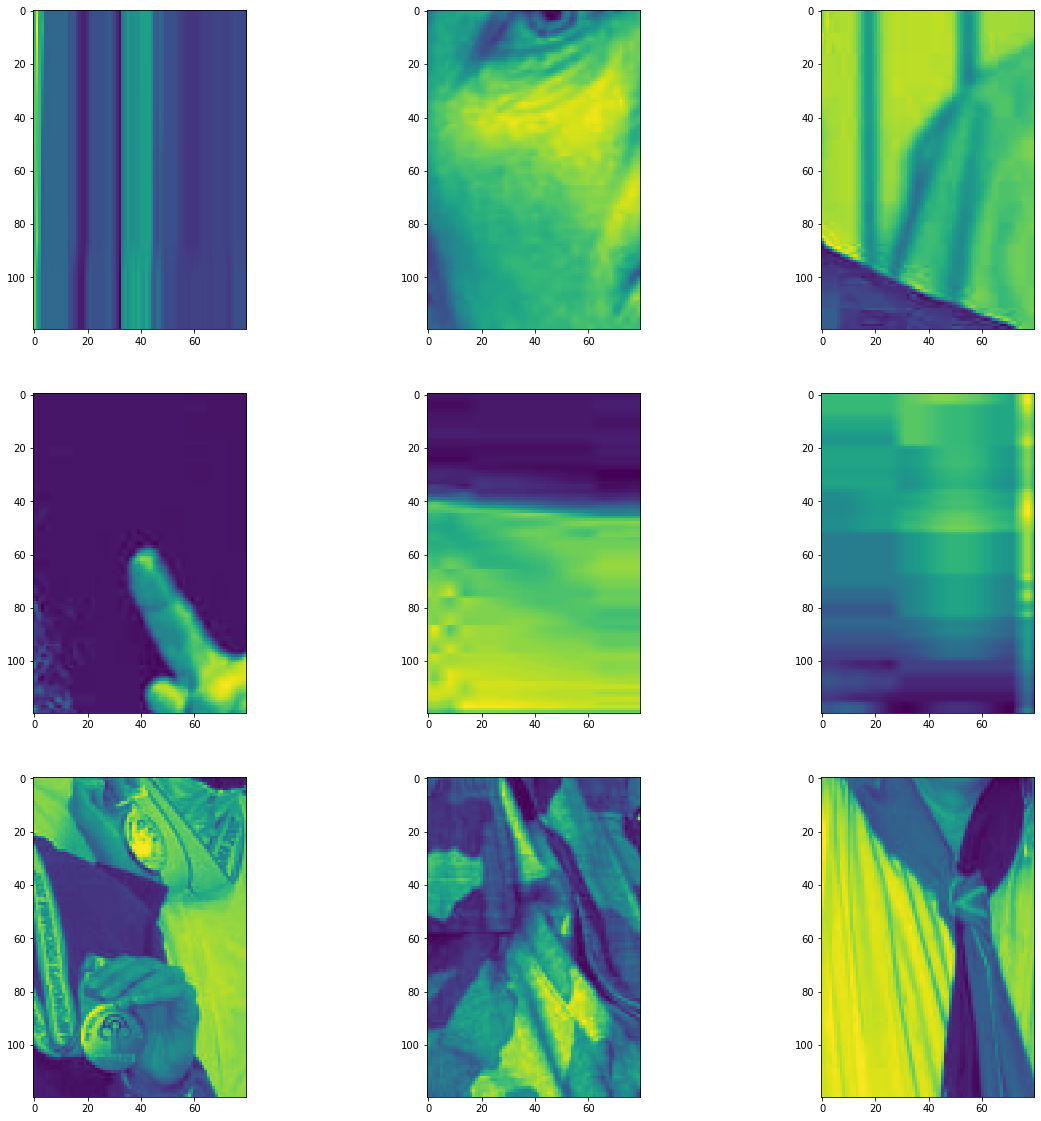

In [13]:
fig, ax = plt.subplots(3, 3, figsize=(20, 20))
idx = 0
nb_sample = data_validation.shape[0]
img_idx = random.sample(range(nb_sample), 9)
for i in range(3):
    for j in range(3):
        ax[i,j].imshow(data_validation[img_idx[idx],:,:])
        idx += 1
plt.show()

In [14]:
label_validation[img_idx]

array([0, 0, 0, 0, 0, 0, 0, 0, 0])

## Modeling

In [15]:
# add the dimension of the channel
# our images are gray, so there is only one channel.
nb_sample, row, col = train_set.shape
X_train = train_set.reshape(nb_sample, row, col, 1)
X_train.shape

(3771, 120, 80, 1)

In [16]:
nb_sample, row, col = data_validation.shape
X_validation = data_validation.reshape(nb_sample, row, col, 1)
X_validation.shape

(2513, 120, 80, 1)

In [17]:
#one-hot encode target column
y_train = to_categorical(target)
y_train

array([[1., 0.],
       [1., 0.],
       [0., 1.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

In [18]:
y_validation = to_categorical(label_validation)
y_validation

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

In [19]:
# create model
# inspired by VGG16
model = Sequential()
model.add(Conv2D(64, (3,3), 
          activation='relu', padding='same', 
          name='block1_conv1', input_shape=(120, 80, 1)))
model.add(MaxPooling2D((2,2), strides=(2,2), name='block1_pool'))

model.add(Conv2D(128, (3,3), activation='relu', padding='same', name='block2_conv1'))
model.add(MaxPooling2D((2,2), strides=(2,2), name='block2_pool'))

model.add(Conv2D(256, (3,3), activation='relu', padding='same', name='block3_conv1'))
model.add(MaxPooling2D((2,2), strides=(2,2), name='block3_pool'))

model.add(Conv2D(256, (3,3), activation='relu', padding='same', name='block4_conv1'))
model.add(MaxPooling2D((2,2), strides=(2,2),name='block4_pool'))

model.add(Flatten())
model.add(Dense(64, activation='relu', name='fc1'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax', name='prediction'))






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [20]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 120, 80, 64)       640       
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 60, 40, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 60, 40, 128)       73856     
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 30, 20, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 30, 20, 256)       295168    
_________________________________________________________________
block3_pool (MaxPooling2D)   (None, 15, 10, 256)       0         
_________________________________________________________________
block4_conv1 (Conv2D)        (None, 15, 10, 256)       590080    
__________

In [21]:
# compile model
model.compile(
    optimizer='sgd',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [22]:
# train model
model.fit(X_train, y_train, validation_data=(X_validation, y_validation),
          batch_size=10, 
          epochs=6)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 3771 samples, validate on 2513 samples
Epoch 1/6
3771/3771 [==============================] - 222s 59ms/step - loss: 0.5102 - acc: 0.7934 - val_loss: 0.4540 - val_acc: 0.7959
Epoch 2/6
3771/3771 [==============================] - 220s 58ms/step - loss: 0.3895 - acc: 0.8059 - val_loss: 0.3501 - val_acc: 0.8261
Epoch 3/6
3771/3771 [==============================] - 222s 59ms/step - loss: 0.2855 - acc: 0.8873 - val_loss: 0.2312 - val_acc: 0.9077
Epoch 4/6
3771/3771 [==============================] - 222s 59ms/step - loss: 0.2007 - acc: 0.9281 - val_loss: 0.1944 - val_acc: 0.9260
Epoch 5/6
3771/3771 [==============================] - 301s 80ms/step - loss: 0.1417 - acc: 0.9454 - val_loss: 0.2126 - val_acc: 0.9236
Epoch 6/6
3771/3771 [==============================] - 226s 60ms/step - loss: 0.1098 - acc: 0.9618 - val_loss: 0.1117 - val_acc: 0.9570


In [23]:
# save model
model.save('./data/models/model_v1.h5')